In [1]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

### Globals

In [2]:
OUTPUT_PATH = 'outputs/'
FEATURES_PATH = 'features/'
ALGORITHMS = ['dp1', 'dp2', 'greedy', 'bf', 'bnb', 'cplex']
LEVELS = [1,2,3,4,5,6]
LEVELS_SIZE = [19198 ,9983, 6664, 4994, 3999, 3333]
FEATURES = ['num_elem',
            'cap',
            'cap_mean_w',
            'cap_median_w', 
            'cap_desv_w', 
            'mean_w_mean_v',
            'median_w_median_v', 
            'desv_w_desv_v',
            'max_w_min_w',
            'max_v_min_v',
            'mean_w',
            'median_w', 
            'desv_w', 
            'min_w', 
            'max_w', 
            'mean_v', 
            'median_v', 
            'desv_v', 
            'min_v', 
            'max_v',
            'p_coef' 
           ]

### Helpers

In [3]:
def get_features(lvl, id_):
    return np.array(open(FEATURES_PATH +str(lvl)+'/'+ str(id_),'r').read().split(), dtype=float)

def get_best(lvl, id_, t):
    best_fo = 0
    best_alg = 0
    best_time = 1000000
    for alg in ALGORITHMS:
        if lvl not in list(alg_data[alg].keys()): continue
        for res in alg_data[alg][lvl][id_]:
            if res[1] < t and res[0] >= best_fo:
                if res[1] < best_time:
                    best_alg = ALGORITHMS.index(alg)+1
                    best_time = res[1]
    return best_alg

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(7), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    plt.xticks(np.arange(7), ('NO', *ALGORITHMS))
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Reading outputs

In [4]:
output_files = os.listdir(OUTPUT_PATH)
alg_data = defaultdict(list)

print("Faltan los siguientes resultados:")
for alg in ALGORITHMS:
    alg_data[alg] = defaultdict(list)
    for lvl in LEVELS:
        filename = alg + "_" + str(lvl)
        if filename not in output_files: # En caso de que todavía no hayan resultados
            print(alg, lvl)
            continue
        alg_data[alg][lvl] = defaultdict(list)
        file = open(OUTPUT_PATH+filename,'r')
        for row in file:
            id_, fo, time = row.split()
            alg_data[alg][lvl][int(id_)].append([(float)(fo), (float)(time)])

Faltan los siguientes resultados:
dp1 6
dp2 3
dp2 4
dp2 5
dp2 6
greedy 5
greedy 6
cplex 6


In [5]:
train_data = []
train_label = []

count = 0

for lvl in LEVELS:
    print("level "+str(lvl)+"...")
    for id_ in range(LEVELS_SIZE[lvl-1]):
        fts = get_features(lvl, id_)
        for t in np.linspace(0.01,6,200):
            train_data.append([*fts, t+1])
            train_label.append(get_best(lvl, id_, t))
        count += 1

level 1...
level 2...
level 3...
level 4...
level 5...
level 6...


In [60]:
# comparing al ojo
lvl_ = 1
id_ = 100
for alg in ALGORITHMS:
    print(alg, alg_data[alg][lvl_][id_])
    
print('BEST: ',ALGORITHMS[get_best(lvl_,id_,1)-1])

dp1 [[753.0, 4e-05]]
dp2 [[753.0, 0.000521]]
greedy [[753.0, 4.8e-05]]
bf [[-1.0, -1.0]]
bnb [[753.0, 0.00126]]
cplex [[3426.0, 0.01586], [753.0, 0.016543]]
BEST:  dp1


In [91]:
data = pd.DataFrame(data=train_data, columns=[*FEATURES, 't'])

## NN

In [1]:

# TensorFlow and tf.keras# Tensor 
import tensorflow as tf
#from tensorflow import keras
#from keras.layers import Dropout, Dense
from keras import Sequential
from keras.models import Model   
from keras.layers import *
# Helper libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/home/isaias/miniconda2/envs/musegan/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Train and Test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=42, verbose=1)

### Saving

In [ ]:
with open('X_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_train)
with open('X_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, X_test)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)
with open('y_test.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_test)

### Loading

In [ ]:
y_train = np.loadtxt('y_train.csv', dtype=float)

In [ ]:
X_train = np.loadtxt('X_train.csv', dtype=float)

### Model

In [ ]:
model = Sequential([
    Dense(128, input_shape = (22,), activation=tf.nn.relu),
    Dropout(0.5),
    Dense(64, activation=tf.nn.relu),
    Dropout(0.5), 
    Dense(64, activation=tf.nn.relu),
    Dropout(0.5), 
    Dense(7, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(np.array(X_train), np.array(y_train), epochs=100, validation_split=0.3)

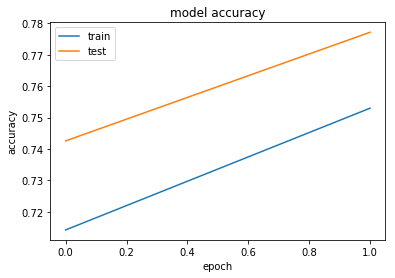

In [183]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

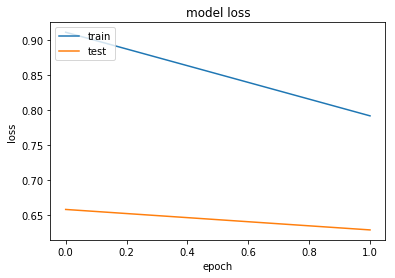

In [184]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluate Accuracy (test set)

In [39]:
X_test = np.loadtxt('X_test.csv', dtype=float)
y_test = np.loadtxt('y_test.csv', dtype=float)

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

1589643/1589643 [==============================] - 22s 14us/step
Test accuracy: 0.8020039719609625


### Individual Predictions

In [121]:
predictions = model.predict(X_test)

[4.62e+02 1.56e+03 2.13e+00 2.14e+00 3.68e+00 9.65e-01 1.00e+00 9.20e-01
 1.54e+03 1.60e+03 7.31e+02 7.28e+02 4.23e+02 9.00e+00 1.55e+03 7.57e+02
 7.28e+02 4.60e+02 1.00e+00 1.60e+03 5.54e-02 1.01e+00]


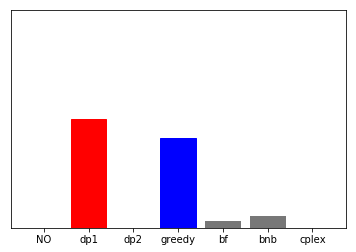

In [140]:
# rojo predicho
# azul verdadero
i = 4
print(X_test[i])
plt.figure()
plot_value_array(i, predictions,  np.array(y_test, dtype=int))

### Confusion matrix

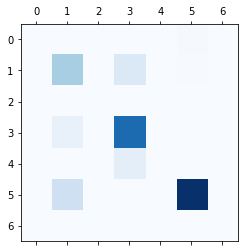

In [169]:
best_predictions = np.argmax(predictions,axis=1)

cm = confusion_matrix(np.array(y_test, dtype=int), best_predictions)

fig, ax = plt.subplots()

ax.matshow(cm, cmap=plt.cm.Blues)

In [24]:
sample = np.array(X_test[0])
sample = (np.expand_dims(sample,0))
predictions_single = model.predict(sample)

print(predictions_single)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [30]:
y_test[0]

6.0